First 5 rows of data:
       date   time  hi1_open  hi1_high  hi1_low  hi1_close  hi1_volume
0  20170703  91400   25524.0   25524.0  25524.0    25524.0       639.0
1  20170703  91500   25530.0   25557.0  25506.0    25547.0       941.0
2  20170703  91600   25549.0   25564.0  25547.0    25560.0       371.0
3  20170703  91700   25558.0   25568.0  25549.0    25568.0       383.0
4  20170703  91800   25568.0   25574.0  25558.0    25562.0       288.0


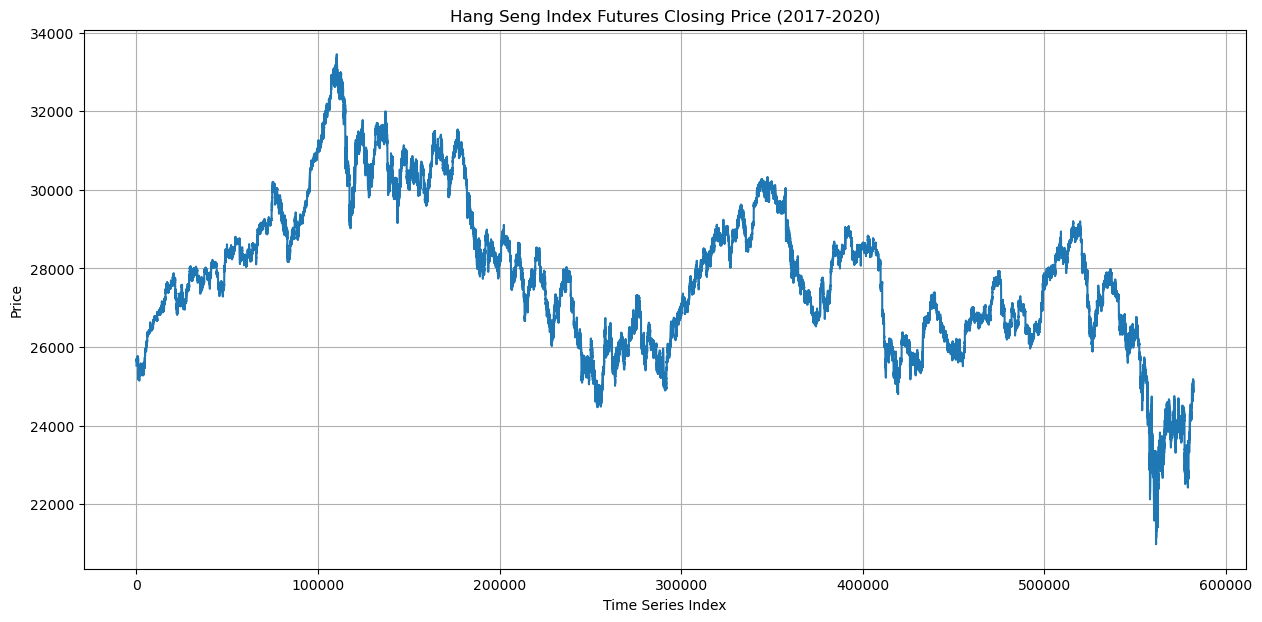

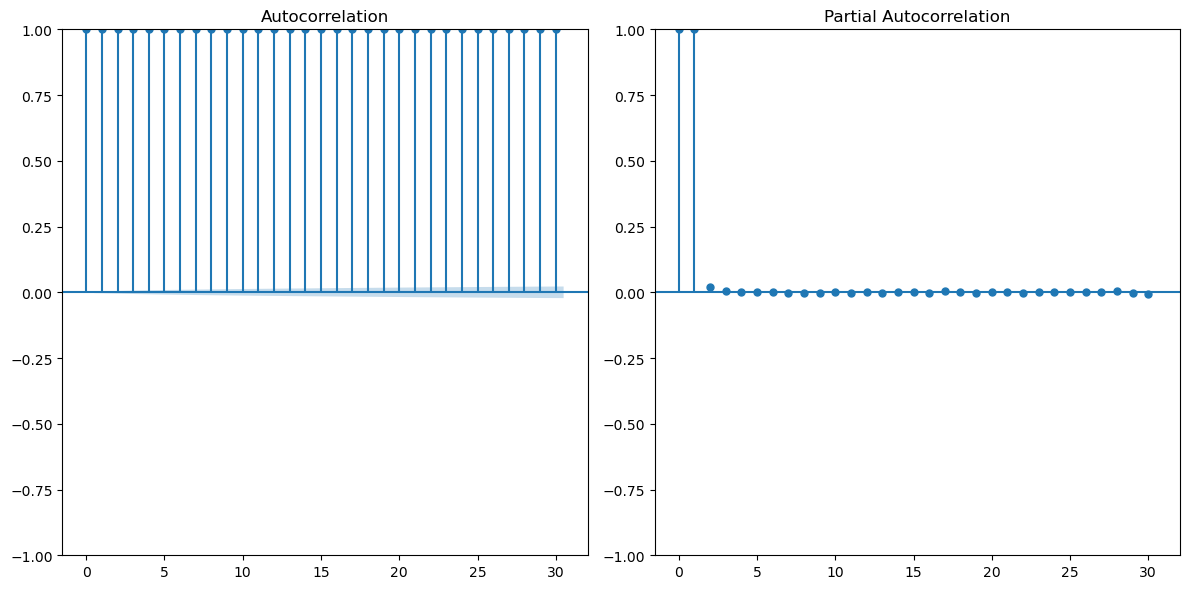

ADF Statistic: -2.231259
p-value: 0.195096
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Series is non-stationary
ARIMA(0,1,1) - AIC: 3560694.3043023013
ARIMA(0,1,2) - AIC: 3560677.8842370515
ARIMA(1,1,0) - AIC: 3560697.1079756846
ARIMA(1,1,1) - AIC: 3560678.7770922123
ARIMA(1,1,2) - AIC: 3560679.9587170132
ARIMA(2,1,0) - AIC: 3560677.8951882357
ARIMA(2,1,1) - AIC: 3560679.8755710167
ARIMA(2,1,2) - AIC: 3560682.5773515543
Best ARIMA model parameters: (0, 1, 2), AIC: 3560677.8842370515
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               465680
Model:                 ARIMA(0, 1, 2)   Log Likelihood            -1780335.942
Date:                Mon, 12 May 2025   AIC                        3560677.884
Time:                        03:22:30   BIC                        3560711.038
Sample:                             0   HQIC                       3560687.298
                            

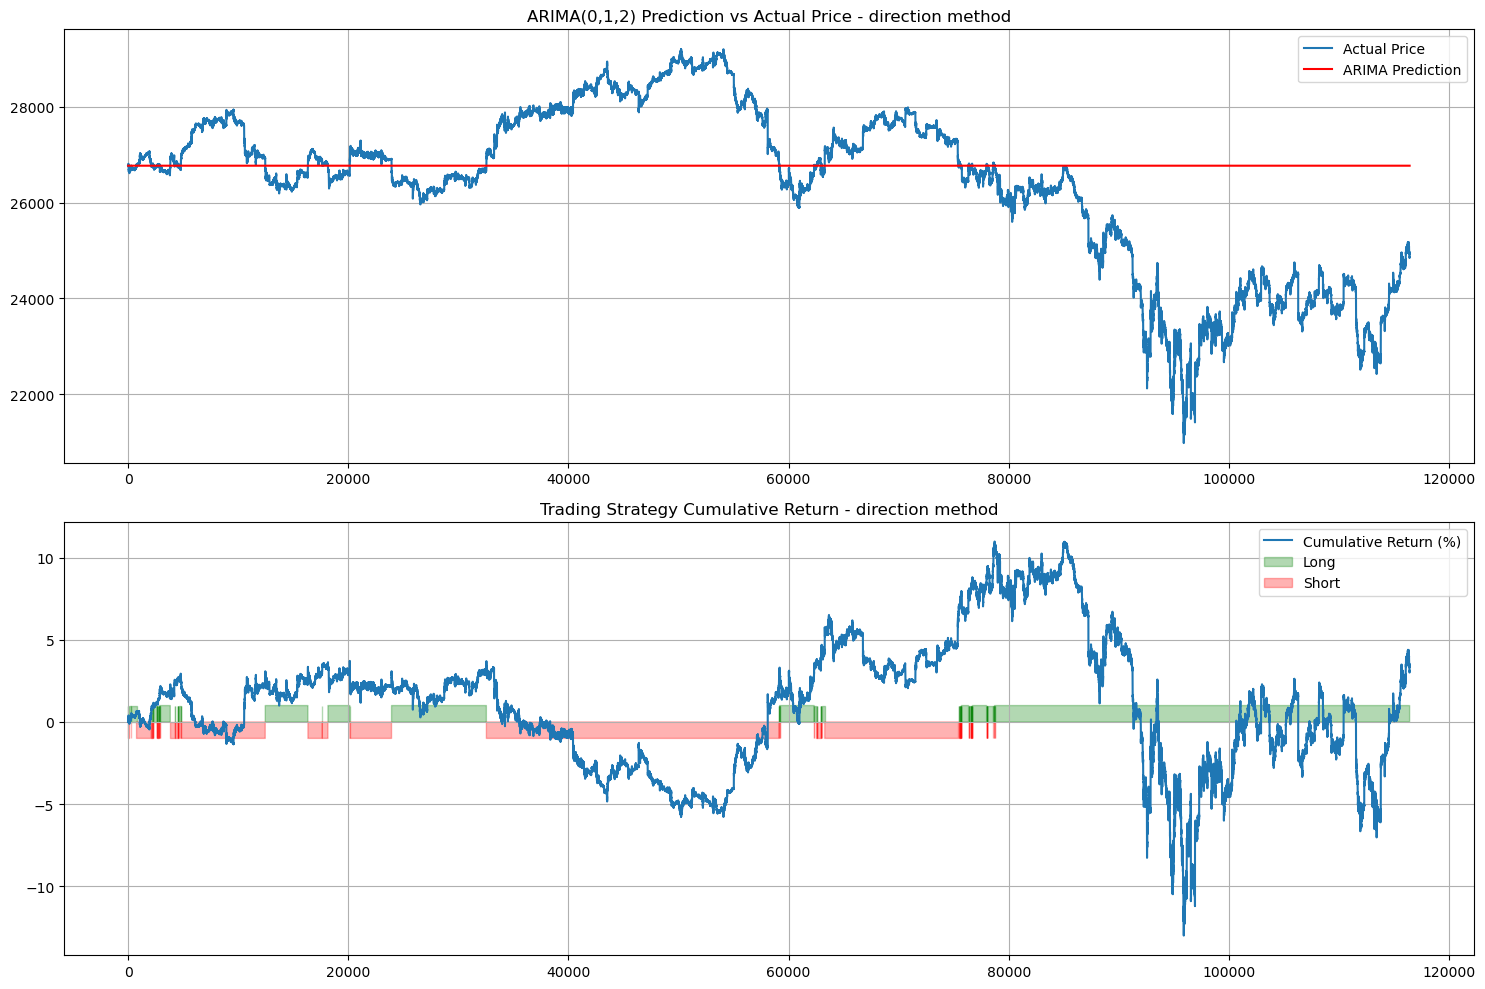

Total Return: 6.32%
Annualized Return: 5.31%
Annualized Volatility: 23.43%
Sharpe Ratio: 0.23
Maximum Drawdown: 23.76%
Win Rate: 27457.67%
Total Trades: 189

Using threshold method to generate signals:


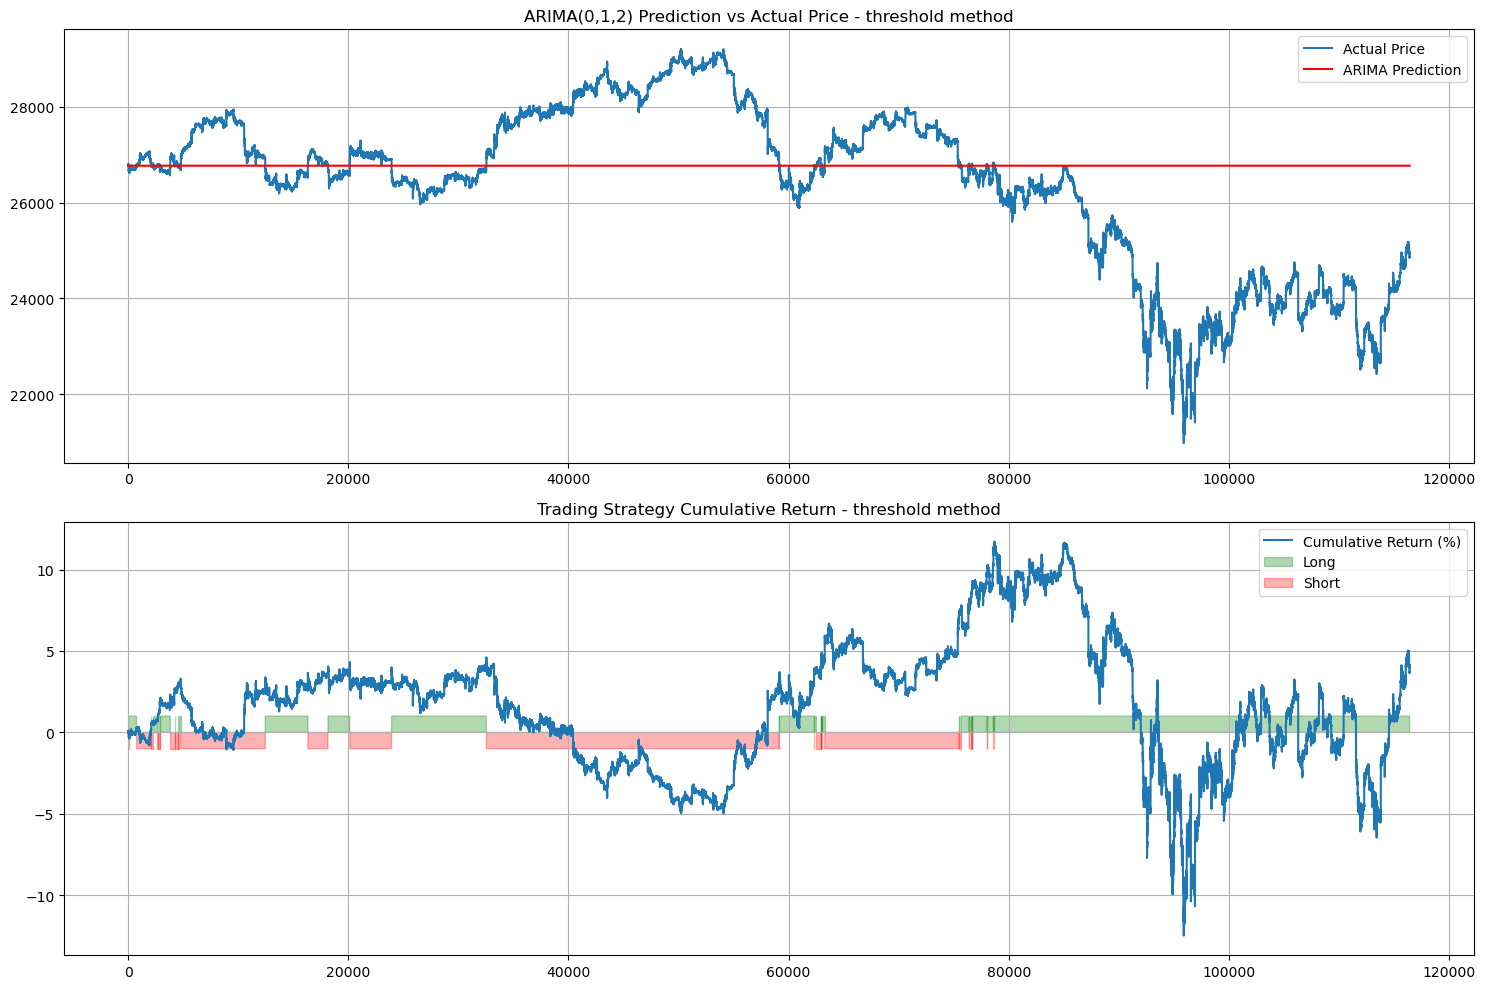

Total Return: 6.93%
Annualized Return: 5.82%
Annualized Volatility: 23.43%
Sharpe Ratio: 0.25
Maximum Drawdown: 23.76%
Win Rate: 78615.15%
Total Trades: 66


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
warnings.filterwarnings('ignore')

# 加载数据 - 不合并日期和时间列
def load_data(file_path):
    # 直接读取CSV文件，第一行是列名
    df = pd.read_csv(file_path)
    # 数据已按时间顺序排列，不需要额外排序
    return df

# 检查时间序列的平稳性
def check_stationarity(timeseries):
    # 进行ADF测试
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # 如果p值小于0.05，则拒绝原假设，序列是平稳的
    is_stationary = result[1] < 0.05
    print(f"Series is {'stationary' if is_stationary else 'non-stationary'}")
    return is_stationary

# 确定最佳ARIMA模型参数
def find_best_arima_model(timeseries, max_p=3, max_d=2, max_q=3):
    best_aic = float("inf")
    best_params = None
    
    # 如果序列非平稳，至少需要一阶差分
    is_stationary = check_stationarity(timeseries)
    min_d = 0 if is_stationary else 1
    
    # 网格搜索最佳参数
    for p, d, q in itertools.product(range(max_p+1), range(min_d, max_d+1), range(max_q+1)):
        if p == 0 and q == 0:
            continue
        
        try:
            model = ARIMA(timeseries, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            
            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q)
                
            print(f"ARIMA({p},{d},{q}) - AIC: {aic}")
        except:
            continue
    
    print(f"Best ARIMA model parameters: {best_params}, AIC: {best_aic}")
    return best_params

# 生成交易信号
def generate_signals(actual_prices, predicted_prices, method='direction', threshold=0.0005):
    signals = np.zeros(len(predicted_prices))
    
    if method == 'direction':
        # 基于预测方向的信号
        for i in range(1, len(predicted_prices)):
            if predicted_prices[i] > actual_prices[i-1]:
                signals[i] = 1  # 买入信号
            elif predicted_prices[i] < actual_prices[i-1]:
                signals[i] = -1  # 卖出信号
    
    elif method == 'threshold':
        # 基于阈值的信号
        for i in range(1, len(predicted_prices)):
            predicted_change = (predicted_prices[i] - actual_prices[i-1]) / actual_prices[i-1]
            if predicted_change > threshold:
                signals[i] = 1
            elif predicted_change < -threshold:
                signals[i] = -1
    
    return signals

# 执行交易并计算收益
def execute_trades(prices, signals):
    positions = np.zeros(len(signals))
    returns = np.zeros(len(signals))
    current_position = 0
    
    for i in range(1, len(signals)):
        # 根据信号更新持仓
        if signals[i] == 1 and current_position <= 0:
            positions[i] = 1
            current_position = 1
        elif signals[i] == -1 and current_position >= 0:
            positions[i] = -1
            current_position = -1
        else:
            positions[i] = current_position
        
        # 计算收益率
        price_change = (prices[i] - prices[i-1]) / prices[i-1]
        returns[i] = positions[i-1] * price_change
    
    # 计算累积收益
    cumulative_returns = np.cumprod(1 + returns) - 1
    
    return positions, returns, cumulative_returns

# 评估策略绩效
def evaluate_strategy(returns, positions):
    total_return = np.sum(returns) * 100
    ann_return = ((1 + np.sum(returns)) ** (252*390/len(returns)) - 1) * 100
    ann_volatility = np.std(returns) * np.sqrt(252*390) * 100
    sharpe_ratio = ann_return / ann_volatility if ann_volatility != 0 else 0
    
    # 计算最大回撤
    cumulative_returns = np.cumsum(returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = running_max - cumulative_returns
    max_drawdown = np.max(drawdown) * 100
    
    # 计算胜率
    profitable_trades = np.sum(returns > 0)
    total_trades = np.sum(np.diff(positions) != 0)
    win_rate = profitable_trades / total_trades * 100 if total_trades > 0 else 0
    
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {ann_return:.2f}%")
    print(f"Annualized Volatility: {ann_volatility:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total Trades: {total_trades}")
    
    return {
        'total_return': total_return,
        'ann_return': ann_return,
        'ann_volatility': ann_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'total_trades': total_trades
    }

# 主程序
def main():
    # 加载数据
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 查看数据前几行
    print("First 5 rows of data:")
    print(df.head())
    
    # 使用收盘价作为目标变量
    close_prices = df['hi1_close'].values
    
    # 划分训练集和测试集
    train_size = int(len(close_prices) * 0.8)
    train, test = close_prices[:train_size], close_prices[train_size:]
    
    # 绘制收盘价时间序列
    plt.figure(figsize=(15, 7))
    plt.plot(close_prices)
    plt.title('Hang Seng Index Futures Closing Price (2017-2020)')
    plt.xlabel('Time Series Index')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
    # 绘制ACF和PACF图以帮助确定模型参数
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(train, ax=plt.gca(), lags=30)
    plt.subplot(122)
    plot_pacf(train, ax=plt.gca(), lags=30)
    plt.tight_layout()
    plt.show()
    
    # 寻找最佳ARIMA模型参数
    best_params = find_best_arima_model(train, max_p=2, max_d=1, max_q=2)
    p, d, q = best_params
    
    # 训练ARIMA模型
    model = ARIMA(train, order=best_params)
    model_fit = model.fit()
    print(model_fit.summary())
    
    # 使用模型进行预测
    predictions = model_fit.forecast(steps=len(test))
    
    # 尝试不同的信号生成方法
    signal_methods = ['direction', 'threshold']
    
    for method in signal_methods:
        print(f"\nUsing {method} method to generate signals:")
        signals = generate_signals(test, predictions, method=method)
        positions, returns, cumulative_returns = execute_trades(test, signals)
        
        # 绘制结果
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 1, 1)
        plt.plot(test, label='Actual Price')
        plt.plot(predictions, color='red', label='ARIMA Prediction')
        plt.title(f'ARIMA({p},{d},{q}) Prediction vs Actual Price - {method} method')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(cumulative_returns * 100, label='Cumulative Return (%)')
        plt.fill_between(range(len(positions)), positions, 0, 
                         where=(positions>0), color='green', alpha=0.3, label='Long')
        plt.fill_between(range(len(positions)), positions, 0, 
                         where=(positions<0), color='red', alpha=0.3, label='Short')
        plt.title(f'Trading Strategy Cumulative Return - {method} method')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # 评估策略绩效
        evaluate_strategy(returns, positions)

if __name__ == "__main__":
    main()


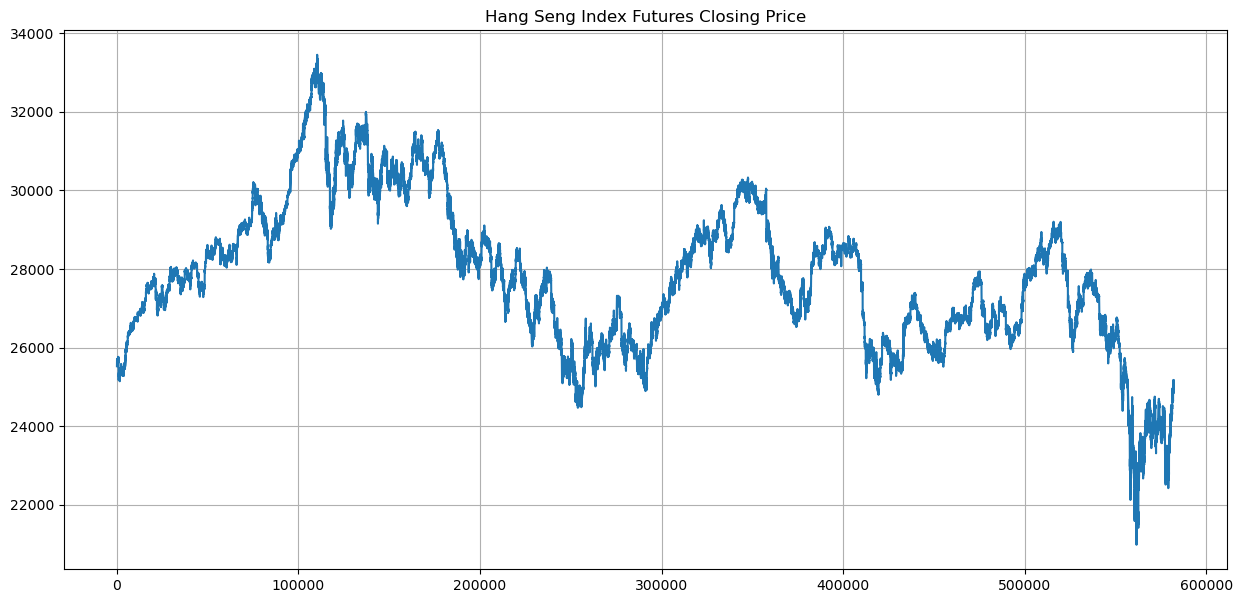

Checking original series:
ADF Test:
ADF Statistic: -2.2355
p-value: 0.1936
Critical Values:
	1%: -3.4304
	5%: -2.8615
	10%: -2.5668
ADF Result: Series is non-stationary

KPSS Test:
KPSS Statistic: 40.0710
p-value: 0.0100
KPSS Result: Series is non-stationary

Conclusion: Series is non-stationary

Checking 1-order differenced series:
ADF Test:
ADF Statistic: -74.8318
p-value: 0.0000
Critical Values:
	1%: -3.4304
	5%: -2.8615
	10%: -2.5668
ADF Result: Series is stationary

KPSS Test:
KPSS Statistic: 0.1248
p-value: 0.1000
KPSS Result: Series is stationary

Conclusion: Series is strongly stationary
Series becomes stationary after 1-order differencing. Optimal d = 1
ARIMA(0,1,1) - AIC: 4633719.7292, BIC: 4633742.2780
ARIMA(0,1,2) - AIC: 4633698.0231, BIC: 4633731.8463
ARIMA(0,1,3) - AIC: 4633698.4833, BIC: 4633743.5809
ARIMA(1,1,0) - AIC: 4633773.7774, BIC: 4633796.3262
ARIMA(1,1,1) - AIC: 4633696.9601, BIC: 4633730.7833
ARIMA(1,1,2) - AIC: 4633696.4397, BIC: 4633741.5372
ARIMA(1,1,3) - AI

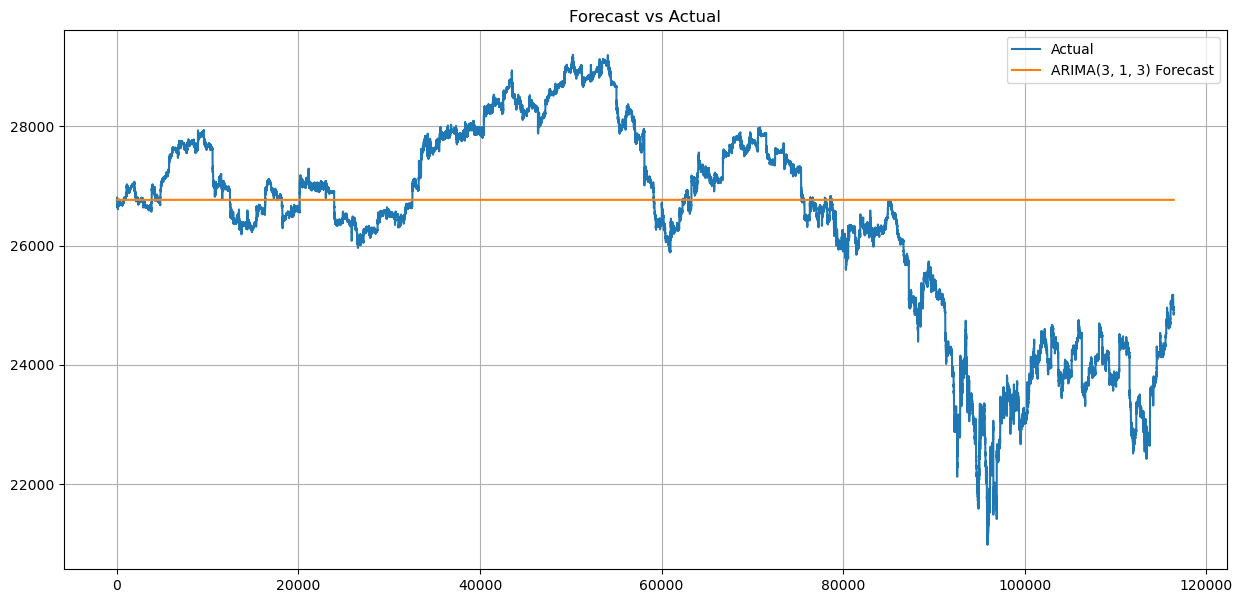

Mean Squared Error: 2988460.5548
Root Mean Squared Error: 1728.7164
Mean Absolute Percentage Error: 5.1047%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
warnings.filterwarnings('ignore')

# 加载数据
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# 综合平稳性检验
def comprehensive_stationarity_check(timeseries, verbose=True):
    # ADF检验
    adf_result = adfuller(timeseries)
    adf_p = adf_result[1]
    adf_stationary = adf_p < 0.05
    
    if verbose:
        print('ADF Test:')
        print(f'ADF Statistic: {adf_result[0]:.4f}')
        print(f'p-value: {adf_p:.4f}')
        print('Critical Values:')
        for key, value in adf_result[4].items():
            print(f'\t{key}: {value:.4f}')
        print(f"ADF Result: Series is {'stationary' if adf_stationary else 'non-stationary'}")
    
    try:
        # KPSS检验
        kpss_result = kpss(timeseries)
        kpss_p = kpss_result[1]
        kpss_stationary = kpss_p > 0.05
        
        if verbose:
            print('\nKPSS Test:')
            print(f'KPSS Statistic: {kpss_result[0]:.4f}')
            print(f'p-value: {kpss_p:.4f}')
            print(f"KPSS Result: Series is {'stationary' if kpss_stationary else 'non-stationary'}")
        
        # 综合判断
        if adf_stationary and kpss_stationary:
            stationarity = "strongly stationary"
            is_stationary = True
        elif adf_stationary and not kpss_stationary:
            stationarity = "trend stationary"
            is_stationary = False
        elif not adf_stationary and kpss_stationary:
            stationarity = "difference stationary"
            is_stationary = False
        else:
            stationarity = "non-stationary"
            is_stationary = False
            
        if verbose:
            print(f"\nConclusion: Series is {stationarity}")
    except:
        # 如果KPSS检验失败，仅使用ADF结果
        stationarity = "stationary" if adf_stationary else "non-stationary"
        is_stationary = adf_stationary
        if verbose:
            print("\nKPSS test failed. Using only ADF result.")
            print(f"Conclusion: Series is {stationarity}")
    
    return is_stationary, stationarity

# 找到最优差分阶数
def find_optimal_d(timeseries, max_d=2):
    original_series = timeseries.copy()
    
    # 检查原始序列
    print("Checking original series:")
    is_stationary, _ = comprehensive_stationarity_check(original_series)
    
    if is_stationary:
        print("Original series is already stationary. Optimal d = 0")
        return 0
    
    # 尝试不同阶数的差分
    for d in range(1, max_d + 1):
        print(f"\nChecking {d}-order differenced series:")
        diff_series = np.diff(original_series, n=d)
        is_stationary, _ = comprehensive_stationarity_check(diff_series)
        
        if is_stationary:
            print(f"Series becomes stationary after {d}-order differencing. Optimal d = {d}")
            return d
    
    print(f"Warning: Series remains non-stationary after {max_d}-order differencing.")
    print(f"Using d = {max_d} as default.")
    return max_d

# 基于ADF检验和信息准则的ARIMA模型选择
def select_best_arima(timeseries, max_p=3, max_q=3, max_d=2):
    # 确定最优差分阶数
    optimal_d = find_optimal_d(timeseries, max_d)
    
    # 对于每个可能的d值，比较信息准则
    best_aic = float("inf")
    best_bic = float("inf")
    best_params_aic = None
    best_params_bic = None
    
    results = []
    
    # 对于最优d值，尝试不同的p和q组合
    for p, q in itertools.product(range(max_p+1), range(max_q+1)):
        if p == 0 and q == 0:
            continue
        
        try:
            model = ARIMA(timeseries, order=(p, optimal_d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            bic = model_fit.bic
            
            results.append({
                'p': p,
                'd': optimal_d,
                'q': q,
                'aic': aic,
                'bic': bic
            })
            
            if aic < best_aic:
                best_aic = aic
                best_params_aic = (p, optimal_d, q)
                
            if bic < best_bic:
                best_bic = bic
                best_params_bic = (p, optimal_d, q)
                
            print(f"ARIMA({p},{optimal_d},{q}) - AIC: {aic:.4f}, BIC: {bic:.4f}")
        except Exception as e:
            print(f"Error with ARIMA({p},{optimal_d},{q}): {str(e)}")
            continue
    
    print(f"\nBest model by AIC: ARIMA{best_params_aic}, AIC: {best_aic:.4f}")
    print(f"Best model by BIC: ARIMA{best_params_bic}, BIC: {best_bic:.4f}")
    
    # 创建结果DataFrame并排序
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('aic')
    
    return best_params_aic, best_params_bic, results_df

# 主函数
def main():
    # 加载数据
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 使用收盘价
    close_prices = df['hi1_close'].values
    
    # 绘制原始时间序列
    plt.figure(figsize=(15, 7))
    plt.plot(close_prices)
    plt.title('Hang Seng Index Futures Closing Price')
    plt.grid(True)
    plt.show()
    
    # 选择最佳ARIMA模型
    best_params_aic, best_params_bic, results_df = select_best_arima(close_prices)
    
    # 显示前5个最佳模型
    print("\nTop 5 models by AIC:")
    print(results_df.head())
    
    # 使用最佳模型进行预测
    p, d, q = best_params_aic  # 使用AIC选择的模型
    
    # 划分训练集和测试集
    train_size = int(len(close_prices) * 0.8)
    train, test = close_prices[:train_size], close_prices[train_size:]
    
    # 训练模型
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())
    
    # 预测
    forecast = model_fit.forecast(steps=len(test))
    
    # 绘制预测结果
    plt.figure(figsize=(15, 7))
    plt.plot(test, label='Actual')
    plt.plot(forecast, label=f'ARIMA{(p,d,q)} Forecast')
    plt.title('Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 计算预测误差
    mse = np.mean((forecast - test) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4f}%")

if __name__ == "__main__":
    main()


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 读取数据
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# 迪基-富勒检验函数
def is_stationary(series, significance=0.05):
    result = adfuller(series)
    p_value = result[1]
    return p_value < significance  # 如果p值小于显著性水平，则拒绝原假设，认为序列是平稳的

# 交易策略实现
def arima_adf_strategy(df):
    # 初始化结果
    trades = []
    balance = 0  # 仅用于跟踪交易
    positions = []  # 1表示多头，-1表示空头，0表示无持仓
    current_position = 0
    
    # 从第62行开始（前60分钟用于建模）
    for i in range(61, len(df)):
        # 获取过去60分钟的收盘价
        past_60_close = df['hi1_close'].iloc[i-60:i].values
        current_price = df['hi1_close'].iloc[i]
        current_date = df['date'].iloc[i]
        current_time = df['time'].iloc[i]
        
        # 检查是否平稳
        if is_stationary(past_60_close):
            try:
                # 构建ARIMA(1,1,1)模型
                model = ARIMA(past_60_close, order=(1, 1, 1))
                model_fit = model.fit()
                
                # 预测下一个值
                forecast = model_fit.forecast(steps=1)[0]
                price_change_prediction = forecast - past_60_close[-1]
                
                # 交易决策
                if price_change_prediction > 0:  # 预测价格上涨
                    if current_position != 1:  # 如果当前不是多头
                        # 平掉旧仓位（如果有）
                        if current_position == -1:
                            profit = current_price  # 平空头的收益
                            balance += profit
                        
                        # 开新仓位
                        balance -= current_price  # 买入
                        current_position = 1
                        trades.append({
                            'date': current_date,
                            'time': current_time,
                            'action': 'BUY',
                            'price': current_price,
                            'balance': balance
                        })
                
                elif price_change_prediction < 0:  # 预测价格下跌
                    if current_position != -1:  # 如果当前不是空头
                        # 平掉旧仓位（如果有）
                        if current_position == 1:
                            profit = current_price  # 平多头的收益
                            balance += profit
                        
                        # 开新仓位
                        balance += current_price  # 卖出
                        current_position = -1
                        trades.append({
                            'date': current_date,
                            'time': current_time,
                            'action': 'SELL',
                            'price': current_price,
                            'balance': balance
                        })
            
            except:
                # 如果ARIMA模型拟合失败，不进行交易
                pass
        
        positions.append(current_position)
    
    # 平掉最后的持仓
    final_price = df['hi1_close'].iloc[-1]
    final_date = df['date'].iloc[-1]
    final_time = df['time'].iloc[-1]
    
    if current_position == 1:
        profit = final_price
        balance += profit
        trades.append({
            'date': final_date,
            'time': final_time,
            'action': 'CLOSE_LONG',
            'price': final_price,
            'balance': balance
        })
    elif current_position == -1:
        profit = -final_price
        balance += profit
        trades.append({
            'date': final_date,
            'time': final_time,
            'action': 'CLOSE_SHORT',
            'price': final_price,
            'balance': balance
        })
    
    # 计算策略表现
    trade_df = pd.DataFrame(trades)
    
    # 计算总收益
    total_profit = balance
    
    # 计算交易次数
    num_trades = len(trades)
    
    # 计算每笔交易的盈亏
    trade_profits = []
    if num_trades > 0:
        for i in range(1, len(trades)):
            if trades[i-1]['action'] == 'BUY' and trades[i]['action'] in ['SELL', 'CLOSE_LONG']:
                trade_profits.append(trades[i]['price'] - trades[i-1]['price'])
            elif trades[i-1]['action'] == 'SELL' and trades[i]['action'] in ['BUY', 'CLOSE_SHORT']:
                trade_profits.append(trades[i-1]['price'] - trades[i]['price'])
        
        # 计算胜率
        win_rate = sum(1 for p in trade_profits if p > 0) / len(trade_profits) * 100 if trade_profits else 0
        
        # 计算平均盈利和平均亏损
        avg_profit = np.mean([p for p in trade_profits if p > 0]) if any(p > 0 for p in trade_profits) else 0
        avg_loss = np.mean([p for p in trade_profits if p < 0]) if any(p < 0 for p in trade_profits) else 0
        
        # 计算盈亏比
        profit_loss_ratio = abs(avg_profit / avg_loss) if avg_loss != 0 else float('inf')
    else:
        win_rate = 0
        avg_profit = 0
        avg_loss = 0
        profit_loss_ratio = 0
    
    return {
        'trades': trade_df,
        'positions': positions,
        'total_profit': total_profit,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'profit_loss_ratio': profit_loss_ratio,
        'trade_profits': trade_profits
    }

# 可视化结果
def plot_results(df, results):
    plt.figure(figsize=(15, 15))
    
    # 绘制价格走势和交易信号
    plt.subplot(3, 1, 1)
    plt.plot(range(61, len(df)), df['hi1_close'].iloc[61:], label='Close Price')
    
    # 标记交易点
    if not results['trades'].empty:
        for i, trade in results['trades'].iterrows():
            # 找到交易在原始数据中的索引
            idx = df[(df['date'] == trade['date']) & (df['time'] == trade['time'])].index
            if len(idx) > 0:
                idx = idx[0]
                if trade['action'] == 'BUY':
                    plt.scatter(idx, trade['price'], color='green', marker='^', s=100)
                elif trade['action'] == 'SELL':
                    plt.scatter(idx, trade['price'], color='red', marker='v', s=100)
    
    plt.title('Price and Trading Signals')
    plt.legend(['Close Price', 'Buy Signal', 'Sell Signal'])
    
    # 绘制账户余额
    plt.subplot(3, 1, 2)
    if not results['trades'].empty:
        plt.plot(range(len(results['trades'])), results['trades']['balance'], label='Account Balance')
    plt.title('Account Balance')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.legend()
    
    # 绘制每笔交易盈亏
    plt.subplot(3, 1, 3)
    if results['trade_profits']:
        plt.bar(range(len(results['trade_profits'])), results['trade_profits'])
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.title('Profit/Loss per Trade')
    
    plt.tight_layout()
    plt.show()

# 主函数
def main():
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 执行策略
    results = arima_adf_strategy(df)
    
    # 打印结果
    print(f"总获利金额: {results['total_profit']:.2f}")
    print(f"交易次数: {results['num_trades']}")
    print(f"胜率: {results['win_rate']:.2f}%")
    print(f"平均盈利: {results['avg_profit']:.2f}")
    print(f"平均亏损: {results['avg_loss']:.2f}")
    print(f"盈亏比: {results['profit_loss_ratio']:.2f}")
    
    # 可视化结果
    plot_results(df, results)
    
    # 保存交易记录
    if not results['trades'].empty:
        results['trades'].to_csv('trading_results.csv', index=False)
        print("交易记录已保存至 trading_results.csv")

if __name__ == "__main__":
    main()


ValueError: Invalid input, x is constant